# Cleaning and Filtering PIRLS data

[PIRLS](https://pirls2021.org/data/). This is where I was able to download all the SPSS files which are separated by country code and survey type. 

SOURCE: IEA’s Progress in International Reading Literacy Study – PIRLS 2021 Copyright © 2023 International Association for the Evaluation of Educational Achievement (IEA). Publisher: TIMSS & PIRLS International Study Center, Lynch School of Education and Human Development, Boston College.

## Importing the Data and relevant packages

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)  # Optional: Set max column width
pd.set_option('display.expand_frame_repr', False)  # Optional: Do not wrap line
import matplotlib.pyplot as plt
import seaborn as sns

The data was merged and organised from multiple datafiles, including Home and Student Context Data for Turkey, Austria, Germany, Egypt, France, Iran, Jordan, The Netherlands and Sweden. To view this process, please click here. 

In [2]:
df= pd.read_excel('data99.xlsx', index_col=0)

In the previous notebook the columns were organised into Home Context Data (columns beginning with 'ASBH'), Student Context Demographic Info and  Experience in School columns (beginning with 'ASBG') and assessment score columns (beginning with 'ASR'). However, it may be more helpful to group these columns in a different way. As a first step I want to take a look at the dataframe on a macro level.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50367 entries, 0 to 50366
Data columns (total 57 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDCNTRY   50367 non-null  int64  
 1   IDSTUD    50367 non-null  int64  
 2   ASBH02A   41503 non-null  object 
 3   ASBH02B   16269 non-null  object 
 4   ASBH03A   41179 non-null  object 
 5   ASBH04    41231 non-null  object 
 6   ASBH15A   37405 non-null  object 
 7   ASBH15B   34597 non-null  object 
 8   ASBH16    40406 non-null  object 
 9   ASBH17A   36503 non-null  object 
 10  ASBH17B   32361 non-null  object 
 11  ASBH18AA  40161 non-null  object 
 12  ASBH18AB  35131 non-null  object 
 13  ASBG01    49428 non-null  object 
 14  ASBG03    48168 non-null  object 
 15  ASDAGE    50358 non-null  float64
 16  ASBG10A   48311 non-null  object 
 17  ASBG10B   48077 non-null  object 
 18  ASBG10C   47893 non-null  object 
 19  ASBG10D   47822 non-null  object 
 20  ASBG10E   47844 non-null  ob

We can see from the above that many columns have have object values meaning that they may contain both numerical and string values - this is something I will need to fix later on. 

## Immigration Status Column

The most important column for this analysis is 'ASBH02A', 'Was your child born in Country?

Firstly, however, I want to remove those that have no answer to this question as there will not be useful in the analysis.

In [4]:
df = df[df['ASBH02A'].notna() & (df['ASBH02A'] != 9)].copy()

In [5]:
df.shape

(41365, 57)

We can see that removing the rows that do not contain immigration data has reduced our dataset by 9002 rows of data. 

As seen above, this column has 'Object' dtype so I want to examine the column values a litte more closely. 

In [6]:
df["ASBH02A"].value_counts(dropna=False)

Yes    25072
1      13403
No      2342
2        548
Name: ASBH02A, dtype: int64

As we can see this column contains both integers and strings. For readibility in the analysis stage I want to replace the integers and the string with a value representing its real meaning.

In [7]:
# Mapping dictionary
update_dict_ASBH02A = {1.0: 'native_born',2.0:'foreign_born','Yes': 'native_born','No':'foreign_born' }

# Updating the column using map
df['ASBH02A'] = df['ASBH02A'].map(update_dict_ASBH02A).fillna(df['ASBH02A'])
df['ASBH02A'].value_counts()

native_born     38475
foreign_born     2890
Name: ASBH02A, dtype: int64

## Country column

Another fundamental column in the subsequent analysis is the IDCNTRY column which currently contains numbers representing different countries.

I will first rename the column for clarity and then update the column values from integers to more readable strings for analysis.

In [8]:
df= df.rename(columns={'IDCNTRY': 'Country'})

# Mapping dictionary
update_dict = {40: 'Austria', 818: 'Egypt', 250:'France', 276:'Germany',364:'Iran',400:'Jordan',528:'Netherlands',752:'Sweden',792:'Turkey'}

# Updating the column using map
df['Country'] = df['Country'].map(update_dict).fillna(df['Country'])

In [9]:
df["Country"].value_counts(dropna=False)

Egypt          7354
Iran           5840
Jordan         5801
Turkey         5596
France         4768
Austria        4476
Sweden         2989
Germany        2515
Netherlands    2026
Name: Country, dtype: int64

## Age of Arrival

The follow up question to ASBH02A is ASBH02B 'If No, How old was your child when he/she came to 'country'?' This column will be helpful to see how age of arrival affects immigrant children's experience of school. 

Let's explore the values in this column.

In [10]:
df['ASBH02B'].value_counts(dropna=False)

NaN                         25234
6                           13402
Younger than 3 years old      928
3 to 5 years old              692
6 to 7 years old              375
8 years old or older          186
1                             182
2                             160
3                             108
4                              63
9                              35
Name: ASBH02B, dtype: int64

As we can see the column contains both strings and integers as countries have inputted their data in different ways. However, we can see from the codebook the corresponding values. So I will assign the corresponding ordinal numbers to the string values.

In [11]:
# Define the function to map patterns to integers
def map_using_patterns(text):
    # Dictionary of regex patterns to integers
    pattern_to_integer = {
        r'Younger': 1,
        r'5': 2,
        r'7': 3,
        r'8': 4
    }

    # Check if the input is a string
    if isinstance(text, str):
        for pattern, integer in pattern_to_integer.items():
            if pd.Series([text]).str.contains(pattern).any():
                return integer
    return text  # Return the original value if it's not a string or no pattern matches

# Apply the function to the 'ASBH02B' column
df['ASBH02B'] = df['ASBH02B'].apply(map_using_patterns)


In [12]:
df['ASBH02B'].value_counts(dropna=False)

NaN    25234
6.0    13402
1.0     1110
2.0      852
3.0      483
4.0      249
9.0       35
Name: ASBH02B, dtype: int64

In order to have more sense-making integers in this column instead of the strings, I am going to assign each -1 to native-born children, 0 to children who were Younger than 3 years old, 3 to 3 to 5 years old 6 to 6 to 7 years old and 8 to 8 years old or older to represent their minimum ages of arrival. 

In [13]:
def populate_column(row):
    if row['ASBH02A'] == 'native_born':
        return -1
    if row['ASBH02B'] == 1:
        return 0
    elif row['ASBH02B'] == 2:
        return 3
    elif row['ASBH02B'] == 3:
        return 6
    elif row['ASBH02B'] == 4:
        return 8
    else:
        return None  # Or any default value

# Apply the function to each row
df['MINAGEARRIVAL'] = df.apply(populate_column, axis=1)

In [14]:
df['MINAGEARRIVAL'].value_counts(dropna=False)

-1.0    38475
 0.0     1110
 3.0      852
 6.0      483
 8.0      249
 NaN      196
Name: MINAGEARRIVAL, dtype: int64

# ASDAGE

Now I want to round the 'ASDAGE' column as it is in decimals and I want it to be in integers for analysis.

In [ ]:
df['ASDAGE'] = df['ASDAGE'].round()

In [ ]:
df['ASDAGE'].value_counts()

In [ ]:
df['ASDAGE']= df['ASDAGE'].replace(99.0, np.nan)

In [ ]:
df['ASDAGE'].value_counts()

## Understanding Missing Data

Now that I have made the 'Country' and 'ASBH02A' columns more readible, and removed rows with no value for the latter column, it would be helpful to understand the extent of missing data across countries, to see if we have any major gaps. 

In [15]:
pivot_table_test = df.pivot_table(
    index=['Country','ASBH02A'],
    aggfunc=lambda x: x.isnull().sum(),
)

In [16]:
# Calculate the total number of elements in each group
total_counts = df.groupby(['Country','ASBH02A']).size()

# Calculate the percentage of missing values
percentage_missing = pivot_table_test.div(total_counts, axis=0) * 100

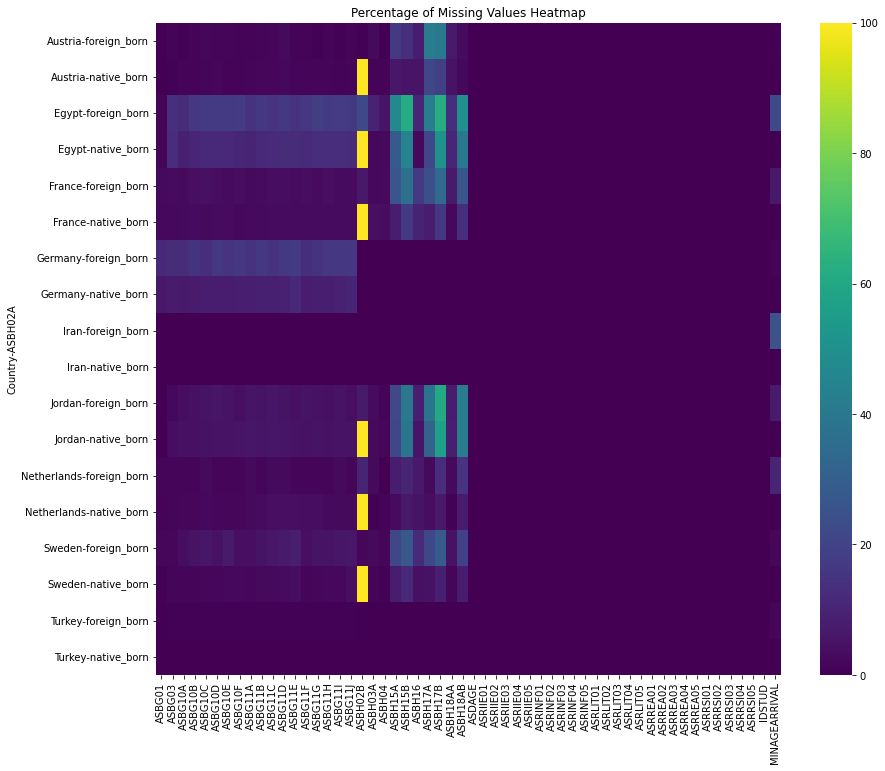

In [17]:
# Create the heatmap
plt.figure(figsize=(14,12 ))
sns.heatmap(percentage_missing, annot=False, cmap='viridis', fmt='.2f')

plt.title('Percentage of Missing Values Heatmap')
plt.show()

As we can see above, the blocks in yellow represent no datapoints at all. This makes sense for native-born children in the columns ASBH02B as that corresponds to age of arrival in country. Austria, Egypt, France, Jordan, Netherlands and Sweden all appear to have some missing data for in the demographic columns sourced from the Home Context Data. There is also some missing data for the experience in school columns. There is no missing data for assessment scores. 

In [18]:
df["ASBH02B"].value_counts(dropna=False)

NaN    25234
6.0    13402
1.0     1110
2.0      852
3.0      483
4.0      249
9.0       35
Name: ASBH02B, dtype: int64

In [20]:
df_native= df[df['ASBH02A']=='native_born']

In [21]:
df_native["ASBH02B"].value_counts(dropna=False)

NaN    25073
6.0    13402
Name: ASBH02B, dtype: int64

## Check germany, iran and turkey have 6 or 9 in the asbh02b column!!!!

## Uniform column values

I want to check all the unique values for each of the columns in my data set so that they are uniform (not mixed, strings with floats) and to remove any values that are not useful. 

For better understanding of the data, I am grouping the columns into 5 groups. These are: identifier_columns, demographic_info_columns, feelings_in_school_columns, experiences_in_school_columns, assessment_score_columns.

### The demographic columns represent our independent variables, whereas feelings_in_school_columns, negativeexperience in school and assessment score columns all contain columns which are dependent variables, metrics for assessing quality education. 

In [22]:
identifier_columns = ['Country','ASBH02A']
demographic_info_columns = ['ASBH02B', 'ASBH03A', 'ASBH04', 'ASBH15A', 'ASBH15B', 'ASBH16', 'ASBH17A', 'ASBH17B', 'ASBH18AA', 'ASBH18AB', 'ASBG01', 'ASBG03', 'ASDAGE','MINAGEARRIVAL' ]
feelings_in_school_columns = ['ASBG10A', 'ASBG10B','ASBG10C', 'ASBG10D', 'ASBG10E', 'ASBG10F']
experiences_in_school_columns = ['ASBG11A', 'ASBG11B', 'ASBG11C', 'ASBG11D', 'ASBG11E', 'ASBG11F', 'ASBG11G', 'ASBG11H', 'ASBG11I', 'ASBG11J']
assessment_score_columns = ['ASRREA01', 'ASRREA02', 'ASRREA03', 'ASRREA04', 'ASRREA05', 'ASRLIT01', 'ASRLIT02', 'ASRLIT03', 'ASRLIT04', 'ASRLIT05', 'ASRINF01', 'ASRINF02', 'ASRINF03', 'ASRINF04', 'ASRINF05', 'ASRIIE01', 'ASRIIE02', 'ASRIIE03', 'ASRIIE04', 'ASRIIE05', 'ASRRSI01', 'ASRRSI02', 'ASRRSI03', 'ASRRSI04', 'ASRRSI05']

### Experience in School

In [23]:
# Apply unique() to each column
unique_values_school_experience = df[experiences_in_school_columns].apply(lambda col: col.unique())

print(unique_values_school_experience)

                 ASBG11A                ASBG11B                ASBG11C                ASBG11D                ASBG11E                ASBG11F                ASBG11G                ASBG11H                ASBG11I                ASBG11J
0                      4                      4                      4                      4                      4                      4                      4                      4                      4                      4
1                      1                      3                      1                      2                      9                      3                      3                      1                      3                      2
2                      3                      1                      3                      1                      3                      1                      1                      3                      1                      3
3                      2                      2                      2  

All the experiences_in_school_columns are rated on the same scale. So I want to remove all the string values and assign them their associated integer value. 

In [24]:
df["ASBG11A"].value_counts(dropna=False)

Never                    16632
4                         6890
A few times a year        4660
At least once a week      4348
Once or twice a month     2707
1                         2126
NaN                       1590
3                         1099
2                         1089
9                          224
Name: ASBG11A, dtype: int64

In [25]:
ordinal_mapping_frequency = {
    'At least once a week': 1,
    'Once or twice a month': 2,
    'A few times a year': 3,
    'Never': 4,
}

In [26]:
for column in experiences_in_school_columns:
    df[column]= df[column].map(ordinal_mapping_frequency).fillna(df[column])

In [27]:
df["ASBG11A"].value_counts(dropna=False)

4.0    23522
1.0     6474
3.0     5759
2.0     3796
NaN     1590
9.0      224
Name: ASBG11A, dtype: int64

In [28]:
df.loc[:, experiences_in_school_columns] = df.loc[:, experiences_in_school_columns].replace(9.0, np.nan)

In [29]:
df["ASBG11A"].value_counts(dropna=False)

4.0    23522
1.0     6474
3.0     5759
2.0     3796
NaN     1814
Name: ASBG11A, dtype: int64

In [30]:
# Apply unique() to each column
unique_values_school_experience = df[experiences_in_school_columns].apply(lambda col: col.unique())

print(unique_values_school_experience)

   ASBG11A  ASBG11B  ASBG11C  ASBG11D  ASBG11E  ASBG11F  ASBG11G  ASBG11H  ASBG11I  ASBG11J
0      4.0      4.0      4.0      4.0      4.0      4.0      4.0      4.0      4.0      4.0
1      1.0      3.0      1.0      2.0      NaN      3.0      3.0      1.0      3.0      2.0
2      3.0      1.0      3.0      1.0      3.0      1.0      1.0      3.0      1.0      3.0
3      2.0      2.0      2.0      3.0      1.0      2.0      NaN      2.0      2.0      1.0
4      NaN      NaN      NaN      NaN      2.0      NaN      2.0      NaN      NaN      NaN


### Feelings in school

In [31]:
# Apply unique() to each column
unique_values_school_feeling = df[feelings_in_school_columns].apply(lambda col: col.unique())

print(unique_values_school_feeling)

             ASBG10A            ASBG10B            ASBG10C            ASBG10D            ASBG10E            ASBG10F
0                  1                  1                  1                  1                  1                  1
1                  2                  2                  2                  2                  2                  2
2                  3                  4                  4                  3                  4                  3
3                  9                  3                  9                  4                  3                  4
4                  4                  9                  3                  9                  9                  9
5                NaN                NaN                NaN                NaN                NaN                NaN
6     Agree a little  Disagree a little     Agree a little     Agree a little  Disagree a little        Agree a lot
7        Agree a lot     Agree a little        Agree a lot        Agree 

All the feelings_in_school_columns are rated on the same scale. So I want to remove all the string values and assign them their associated integer value.

In [32]:
df["ASBG10A"].value_counts(dropna=False)

Agree a lot          17353
1                     9630
Agree a little        8110
Disagree a little     1798
Disagree a lot        1377
NaN                   1300
2                     1167
4                      252
3                      194
9                      184
Name: ASBG10A, dtype: int64

In [33]:
ordinal_mapping_agreement = { 
    'Agree a lot': 1,
    'Agree a little': 2,
    'Disagree a little': 3,
    'Disagree a lot': 4
}

In [34]:
for column in feelings_in_school_columns:
    df[column]= df[column].map(ordinal_mapping_agreement).fillna(df[column])

In [35]:
df["ASBG10A"].value_counts(dropna=False)

1.0    26983
2.0     9277
3.0     1992
4.0     1629
NaN     1300
9.0      184
Name: ASBG10A, dtype: int64

In [36]:
df.loc[:, feelings_in_school_columns] = df.loc[:, feelings_in_school_columns].replace(9.0, np.nan)

In [37]:
df["ASBG10A"].value_counts(dropna=False)

1.0    26983
2.0     9277
3.0     1992
4.0     1629
NaN     1484
Name: ASBG10A, dtype: int64

In [38]:
# Apply unique() to each column
unique_values_school_feeling = df[feelings_in_school_columns].apply(lambda col: col.unique())

print(unique_values_school_feeling)

   ASBG10A  ASBG10B  ASBG10C  ASBG10D  ASBG10E  ASBG10F
0      1.0      1.0      1.0      1.0      1.0      1.0
1      2.0      2.0      2.0      2.0      2.0      2.0
2      3.0      4.0      4.0      3.0      4.0      3.0
3      NaN      3.0      NaN      4.0      3.0      4.0
4      4.0      NaN      3.0      NaN      NaN      NaN


## Summary

In [ ]:
df.info()

## Other Demographic Columns

We will leave the other demographic columns for the time being as we are primarily concerned with one column for our initial analysis - ASBH02A - born in country. 

## Filtering the data 

# Could Identify outliers and look at their complete rows - could be fun

Now I am concerned with removing any rows of data (each representing one student) with irregular assessment score values as such values could skew the analysis. 

I will start by adding an average score column to my dataframe.

In [39]:
df['avgscore'] = df[assessment_score_columns].mean(axis=1)

In [40]:
df['avgscore'].describe()

count    41365.000000
mean       465.338100
std        111.880952
min         84.541739
25%        394.414970
50%        482.298914
75%        550.326946
max        757.011431
Name: avgscore, dtype: float64

So our maximum average score is 757.011431 and our minimum is 84.541739. These scores are both quite far from the mean of 465. 34. I'm wondering if some of these are anomalies and we therefore want to delete rows with values under and over a certain amount.

## Boxplot Visualisation

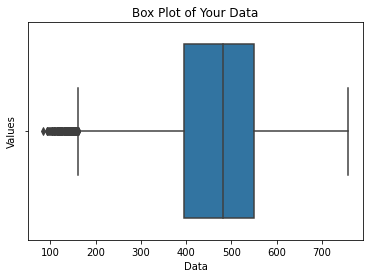

In [41]:
# Create a box plot
sns.boxplot(x=df['avgscore'])

# Add title and labels
plt.title('Box Plot of Your Data')
plt.xlabel('Data')
plt.ylabel('Values')

# Show the plot
plt.show()

Interpretation
Central Box: Represents the interquartile range (IQR), containing the middle 50% of the data.
Line inside the Box: Indicates the median of the data.
Whiskers: Extend to the smallest and largest values within 1.5 * IQR from the lower and upper quartiles.
Dots outside the Whiskers: Represent potential outliers.


I want to consider whether filtering the data using either the zscore method or the interquartile range would make this selection more reliable. 

## Zscore

In [42]:
# Method 1: Z-score method
from scipy.stats import zscore

# Calculate the Z-scores
df['zscore'] = zscore(df['avgscore'])

# Define a threshold (e.g., 3)
threshold = 3

# Filter the data to remove outliers
df_zscore_filtered = df[(df['zscore'] < threshold) & (df['zscore'] > -threshold)]

## IQR Method

In [43]:
# Method 2: IQR method
Q1 = df['avgscore'].quantile(0.25)
Q3 = df['avgscore'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
df_iqr_filtered = df[(df['avgscore'] >= lower_bound) & (df['avgscore'] <= upper_bound)]

## Comparison of the three datasets

In [44]:
summary_original = df['avgscore'].describe()
summary_zscore_filtered = df_zscore_filtered['avgscore'].describe()
summary_iqr_filtered = df_iqr_filtered['avgscore'].describe()

In [45]:
print("Original Data Summary:")
print(summary_original)
print("\nZ-score Filtered Data Summary:")
print(summary_zscore_filtered)
print("\nIQR Filtered Data Summary:")
print(summary_iqr_filtered)

Original Data Summary:
count    41365.000000
mean       465.338100
std        111.880952
min         84.541739
25%        394.414970
50%        482.298914
75%        550.326946
max        757.011431
Name: avgscore, dtype: float64

Z-score Filtered Data Summary:
count    41318.000000
mean       465.738188
std        111.312929
min        130.611489
25%        394.757593
50%        482.429018
75%        550.398401
max        757.011431
Name: avgscore, dtype: float64

IQR Filtered Data Summary:
count    41158.000000
mean       466.971053
std        109.754016
min        160.574553
25%        395.985095
50%        483.052609
75%        550.627011
max        757.011431
Name: avgscore, dtype: float64


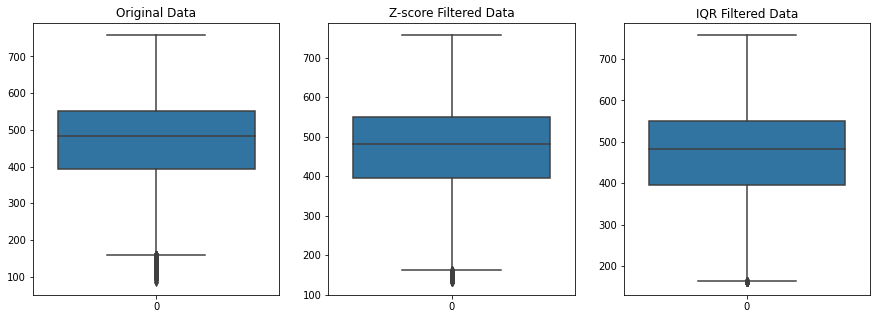

In [46]:
# Visualize distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(df['avgscore'])
plt.title('Original Data')

plt.subplot(1, 3, 2)
sns.boxplot(df_zscore_filtered['avgscore'])
plt.title('Z-score Filtered Data')

plt.subplot(1, 3, 3)
sns.boxplot(df_iqr_filtered['avgscore'])
plt.title('IQR Filtered Data')

plt.show()

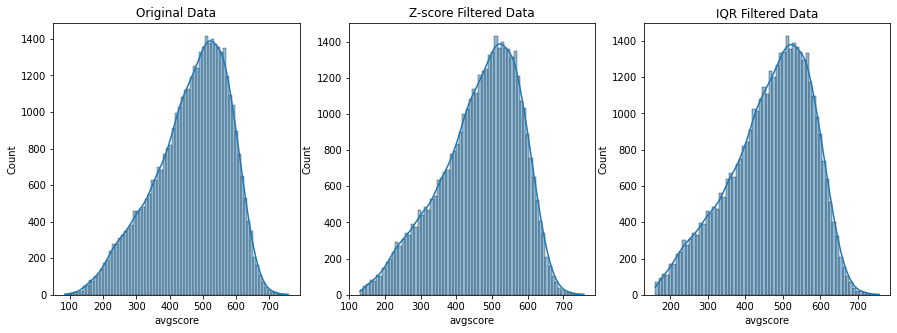

In [47]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['avgscore'], kde=True)
plt.title('Original Data')

plt.subplot(1, 3, 2)
sns.histplot(df_zscore_filtered['avgscore'], kde=True)
plt.title('Z-score Filtered Data')

plt.subplot(1, 3, 3)
sns.histplot(df_iqr_filtered['avgscore'], kde=True)
plt.title('IQR Filtered Data')

plt.show()

Analysis and Comparison
Summary Statistics: Compare the mean, median, standard deviation, and other statistics to see how each method affects the central tendency and spread of the data.
Visual Inspection: Use box plots to visually inspect the data distribution and outliers in each dataset. Use histograms to compare the frequency distributions.
Impact on Analysis: Perform key analyses (e.g., regression, clustering) on both filtered datasets and compare the results to understand the impact of outlier removal.
Documenting Findings
Descriptive Statistics: Summarize how the descriptive statistics differ across the datasets.
Visual Differences: Highlight any noticeable differences in the box plots and histograms.
Analytical Impact: Discuss how outlier removal affects your main analysis, noting any significant changes in results or interpretations.
By comparing the filtered datasets, you can determine which method of outlier removal is more appropriate for your data and analysis goals, providing a deeper understanding of the impact of outliers on your analysis.

## Chi Square Test - remove?

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
def perform_chi_square_test(df, score_column, category_column, bins=10):
    """
    Perform a Chi-Square Test of Independence on a given DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        score_column (str): The column name containing the numeric scores to be binned.
        category_column (str): The column name of the categorical variable.
        bins (int): The number of bins for discretizing the score column. Default is 10.

    Returns:
        tuple: Chi-Square test statistic, p-value, degrees of freedom, expected frequencies.
    """
    # Bin the score column
    df['binned_scores'] = pd.cut(df[score_column], bins=bins)

    # Create a contingency table
    contingency_table = pd.crosstab(df[category_column], df['binned_scores'])

    # Perform Chi-Square Test of Independence
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print results
    print(f"Chi-Square Test Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")

    return chi2, p, dof, expected

In [ ]:
perform_chi_square_test(df, 'avgscore', 'ASBH02A', bins=10)

In [ ]:
perform_chi_square_test(df_zscore_filtered, 'avgscore', 'ASBH02A', bins=10)

In [ ]:
perform_chi_square_test(df_iqr_filtered, 'avgscore', 'ASBH02A', bins=10)

Unfiltered Dataset
Chi-Square Test Statistic: 245.83 (very large value)
P-value: 
7.55
×
1
0
−
48
7.55×10 
−48
  (extremely small, essentially 0)
Interpretation: The null hypothesis is rejected with very high confidence. There is a significant association or effect detected in the unfiltered data.
Z-Score Filtered Dataset
Chi-Square Test Statistic: 3.94 (very small value)
P-value: 0.915 (very high, close to 1)
Interpretation: The null hypothesis cannot be rejected. The z-score filtering appears to have removed most of the association or effect, likely by excluding outliers or influential data points.
IQR Filtered Dataset
Chi-Square Test Statistic: 248.94 (very large value, even larger than unfiltered)
P-value: 
1.67
×
1
0
−
48
1.67×10 
−48
  (extremely small, essentially 0)
Interpretation: Similar to the unfiltered data, the null hypothesis is rejected with very high confidence. This suggests that the IQR filtering preserved or even amplified the detected effect.
Comparison of Results
Effect of Filtering:

Z-score filtering greatly reduced the test statistic and increased the p-value, possibly due to the removal of extreme values, which may have carried most of the signal.
IQR filtering retained or enhanced the strength of the signal, leading to similar or even stronger rejection of the null hypothesis compared to the unfiltered dataset.
Significance:

The unfiltered and IQR-filtered datasets indicate a strong and statistically significant result.
The z-score filtered dataset suggests no significant result, likely due to the removal of key influential points.
Interpretation of Filtering Methods:

Z-score Filtering: This method likely excludes extreme outliers based on standard deviations, which can minimize the effect of influential data points but may also discard important variations.
IQR Filtering: By focusing on the central 50% of the data, this method avoids extreme outliers while retaining much of the inherent variation, preserving the signal.
Conclusion
The unfiltered and IQR-filtered datasets suggest strong evidence against the null hypothesis.
Z-score filtering may overly simplify the data by removing too much information, leading to an insignificant result. It’s important to consider the nature of the data and the appropriateness of the filtering technique for the given analysis.





You said:
So do you think I should continue my analysis with the IQR-filtered dataset? Is it normal to get such different results between the z-score filtered df and IQR-filtered?
ChatGPT said:
ChatGPT
Yes, continuing your analysis with the IQR-filtered dataset is a reasonable choice, particularly if your goal is to balance removing extreme outliers without losing critical information about the dataset's central tendencies. Here’s why:

1. The Case for the IQR-Filtered Dataset
Preservation of Signal: The IQR filtering retains much of the variation in the data while removing extreme outliers (points outside the interquartile range). The fact that the Chi-square test statistic is nearly identical to the unfiltered dataset suggests that the key relationships in the data remain intact.
Outlier Management: IQR filtering removes extreme points that could skew results without discarding moderate variations that might still carry useful information.
2. Is it Normal to Get Different Results Between Z-Score and IQR Filtering?
Yes, it’s quite common to see different results between these two methods because they handle outliers differently:

Z-Score Filtering:

Focuses on removing data points that deviate significantly (e.g., beyond 3 standard deviations) from the mean.
May remove both large and small values indiscriminately, especially in datasets with non-normal distributions or heavy tails.
Can lead to the loss of critical variations or signals if your dataset inherently has high variability or non-Gaussian characteristics.
IQR Filtering:

Targets the tails of the distribution, but only those points beyond the 1.5x IQR from the first or third quartile.
More robust for non-Gaussian distributions or datasets with skewed distributions because it doesn't depend on the mean and standard deviation.
The stark difference in p-values (0.915 for z-score filtering versus 
1.67
×
1
0
−
48
1.67×10 
−48
  for IQR filtering) likely reflects that z-score filtering removed influential data points that were driving the significant association in your analysis. If these removed points are not true "noise" but meaningful data, the z-score method might underrepresent the true relationships in your data.

3. Considerations
Before proceeding exclusively with the IQR-filtered dataset:

Understand Your Data:

Examine the distributions of the variables and determine if they are skewed, have heavy tails, or contain clusters of outliers. This will guide you in confirming whether z-score filtering was overly aggressive.
Validate Robustness:

Cross-check key findings across both filtered datasets to ensure that your conclusions aren’t overly dependent on the choice of filtering. The fact that the unfiltered and IQR-filtered datasets yield similar results is reassuring.
Interpret Outliers:

Investigate the nature of the outliers. If outliers represent valid observations (e.g., rare but meaningful phenomena), they should not be filtered out too aggressively.
4. Recommendation
Based on your results and standard practices:

Use the IQR-filtered dataset for your main analysis, as it preserves the data's key relationships and balances outlier removal.
Optionally, provide a sensitivity analysis with the z-score filtered dataset in your final report. This will demonstrate the robustness of your findings under different preprocessing methods.
In summary, the differences between filtering methods highlight the importance of choosing the one most aligned with the characteristics of your data. The IQR-filtered dataset appears to strike the right balance in your case!

In [48]:
df_iqr_filtered.to_excel("cleandataiqr17125.xlsx")

In [49]:
df_iqr_filtered.shape

(41158, 60)